In [59]:
import rasterio
import os
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform_bounds

from pyproj import CRS

import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np

import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject

In [3]:
DATA_DIR = "data"
ASSET_1 = os.path.join(DATA_DIR, '3B-HHR-E_MS_MRG_3IMERG_20230101-S000000-E002959_0000_V06C_30min.tiff')

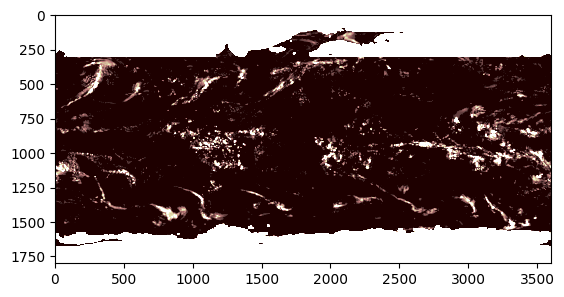

In [39]:
def plot_asset(tiff_file):
    src = rasterio.open(tiff_file)
    pyplot.imshow(src.read(1), cmap='pink', vmin=0.1, vmax=10)
    pyplot.show()


# Example usage
plot_asset(ASSET_1)

In [102]:
# Test
src = rasterio.open(ASSET_1)
src.scales

(1.0,)

## Band Selection
This is dependant on meta data of the COG. If there are no band names added in band meta data, we can't query using it.

In [100]:
def select_band(infile, band_name, outfile):
    src = rasterio.open(infile)
    band_names = src.descriptions
    if band_names is None or len(band_names) == 0:
        raise ValueError("No band name found")
    band_names = list(band_names)

    band_index = band_names.index(band_name) + 1
    band_data = src.read(band_index)
    out_meta = src.meta.copy()
    out_meta.update({
        'count': 1,  # Number of bands in the output file
        'dtype': 'float32'  # Adjust data type as needed for your calculations
    })
    with rasterio.open(outfile, 'w', **out_meta) as dest:
        dest.write(band_data, 1)



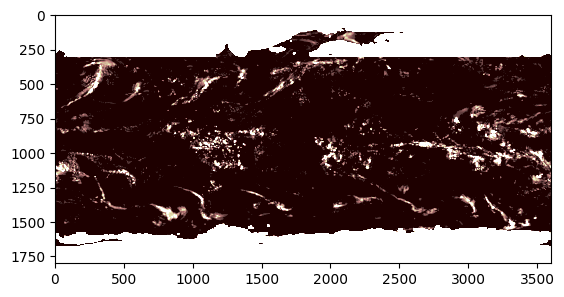

In [105]:
band_file = os.path.join(DATA_DIR, 'out', 'band1.tiff')

select_band(ASSET_1, 'precipitationCal', band_file)

plot_asset(band_file)

## Reprojection

### Simple reprojection

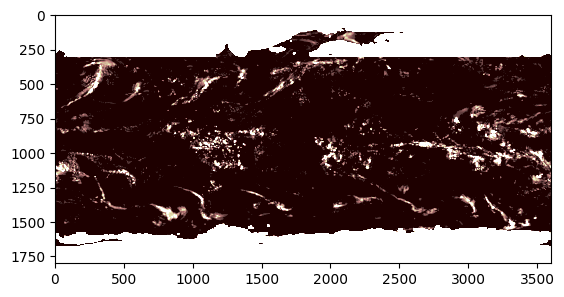

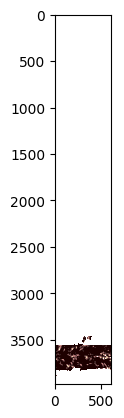

In [32]:

def reproject_image(asset_id, source_crs, dest_crs, dest_path):
    with rasterio.open(asset_id) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dest_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dest_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dest_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dest_crs,
                    resampling=Resampling.nearest)

out_asset = os.path.join(DATA_DIR, 'out', 'test1.tiff')
reproject_image(ASSET_1, 'EPSG:4326', 'EPSG:3857', out_asset)
plot_asset(ASSET_1)
plot_asset(out_asset)

### Scaling
Was not able to find any direct method of scaling images like EE.

## Clipping
Clipping is supported via a BBOX.

### Simple clipping

In [89]:
def clip_tiff_with_bbox(input_tiff_path, output_tiff_path, bbox, crop=True):
    """
    Clips a GeoTIFF file to the specified bounding box.

    Parameters:
    - input_tiff_path: Path to the input GeoTIFF file.
    - output_tiff_path: Path where the clipped GeoTIFF will be saved.
    - bbox: A tuple of (min_lon, min_lat, max_lon, max_lat) defining the bounding box.

    Returns:
    None
    """
    # Open the input GeoTIFF file
    with rasterio.open(input_tiff_path) as src:
        # Convert the bounding box into a geometry (in GeoJSON format)
        bbox_geom = {
            'type': 'Polygon',
            'coordinates': [[
                [bbox[0], bbox[1]],
                [bbox[2], bbox[1]],
                [bbox[2], bbox[3]],
                [bbox[0], bbox[3]],
                [bbox[0], bbox[1]]
            ]]
        }
        
        # Use the geometry to generate a mask
        out_image, out_transform = mask(src, [bbox_geom], crop=crop)
        out_meta = src.meta.copy()

        # Update the metadata with the new dimensions, transform, and CRS
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # Write the clipped raster to a new GeoTIFF file
        with rasterio.open(output_tiff_path, "w", **out_meta) as dest:
            dest.write(out_image)

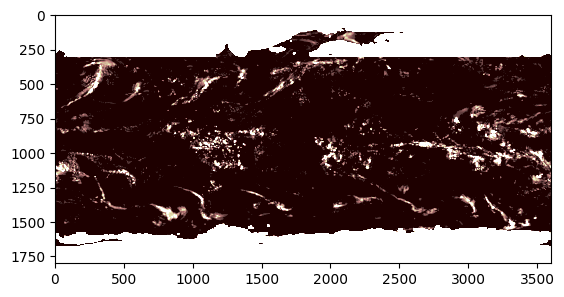

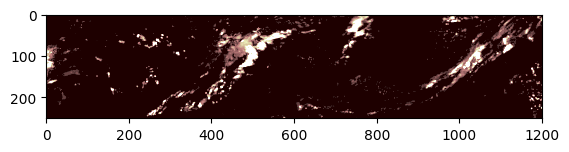

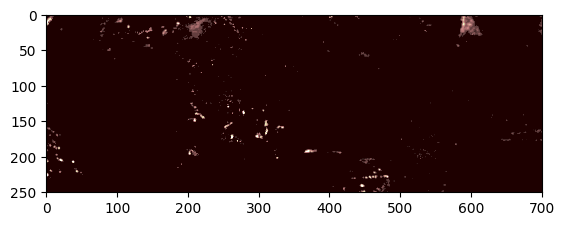

In [110]:
usa_clip_path = os.path.join(DATA_DIR, 'out', 'usa_clip.tiff')
india_clip_path = os.path.join(DATA_DIR, 'out', 'india_clip.tiff')
no_clip_path = os.path.join(DATA_DIR, 'out', 'no_clip.tiff')

bbox = (-120.0, 24.0, -60, 49.0)
bbox2 = (0, 24 ,70, 49)
bbox = (-120.0, 24.0, 0, 49.0)
clip_tiff_with_bbox(ASSET_1, usa_clip_path, bbox)
clip_tiff_with_bbox(ASSET_1, india_clip_path, bbox2)

plot_asset(ASSET_1)
plot_asset(usa_clip_path)
plot_asset(india_clip_path)

### Out of bounds clipping

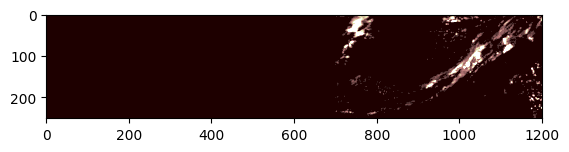

In [111]:
clip_tiff_with_bbox(usa_clip_path, no_clip_path, bbox3, crop=False)

plot_asset(no_clip_path)

## Apply operators
We can apply operations on bands. The below example is a simple operation on band1 of the image.
We can make a parser that takes in an expression string and applies the operations accordingly.

In [53]:
def apply(input_file, output_file):
    with rasterio.open(input_file) as src:
        band1 = src.read(1)

        # Replace with any operation
        result_band = band1 * 10
        out_meta = src.meta.copy()

        out_meta.update({
            'count': 1,
            'dtype': 'float32'
        })

    with rasterio.open(output_file, 'w', **out_meta) as dest:
        dest.write(result_band, 1)

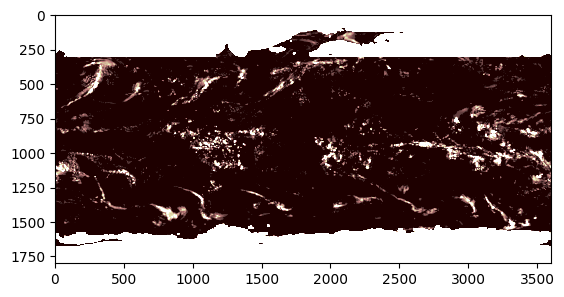

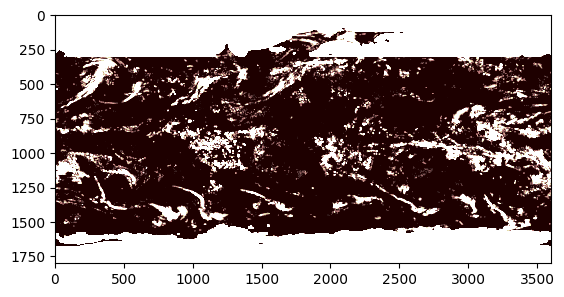

In [56]:
op_file = os.path.join(DATA_DIR, 'out', 'op.tiff')
apply(ASSET_1, op_file)

plot_asset(ASSET_1)
plot_asset(op_file)